In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

import lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [4]:
# read file csv
df= pd.read_csv("./bank/bank-full.csv")
df[df['y'] == 'yes'].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
83,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
86,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
168,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Penjelasan data
#### bank client data:
1. age (numeric)
2. job : type of job (categorical:"admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

#### related with the last contact of the current campaign:
9. contact: contact communication type (categorical:"unknown","telephone","cellular") 
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

##### other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric,.1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

##### Output variable (desired target):
17. y - has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
print(df.shape)
#df[df['month'] == 'jan'].shape[0]
df['poutcome'].value_counts()

(45211, 17)


unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

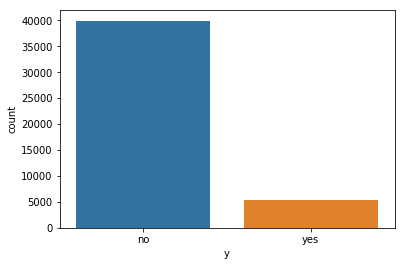

In [5]:
sns.countplot(x = df["y"])

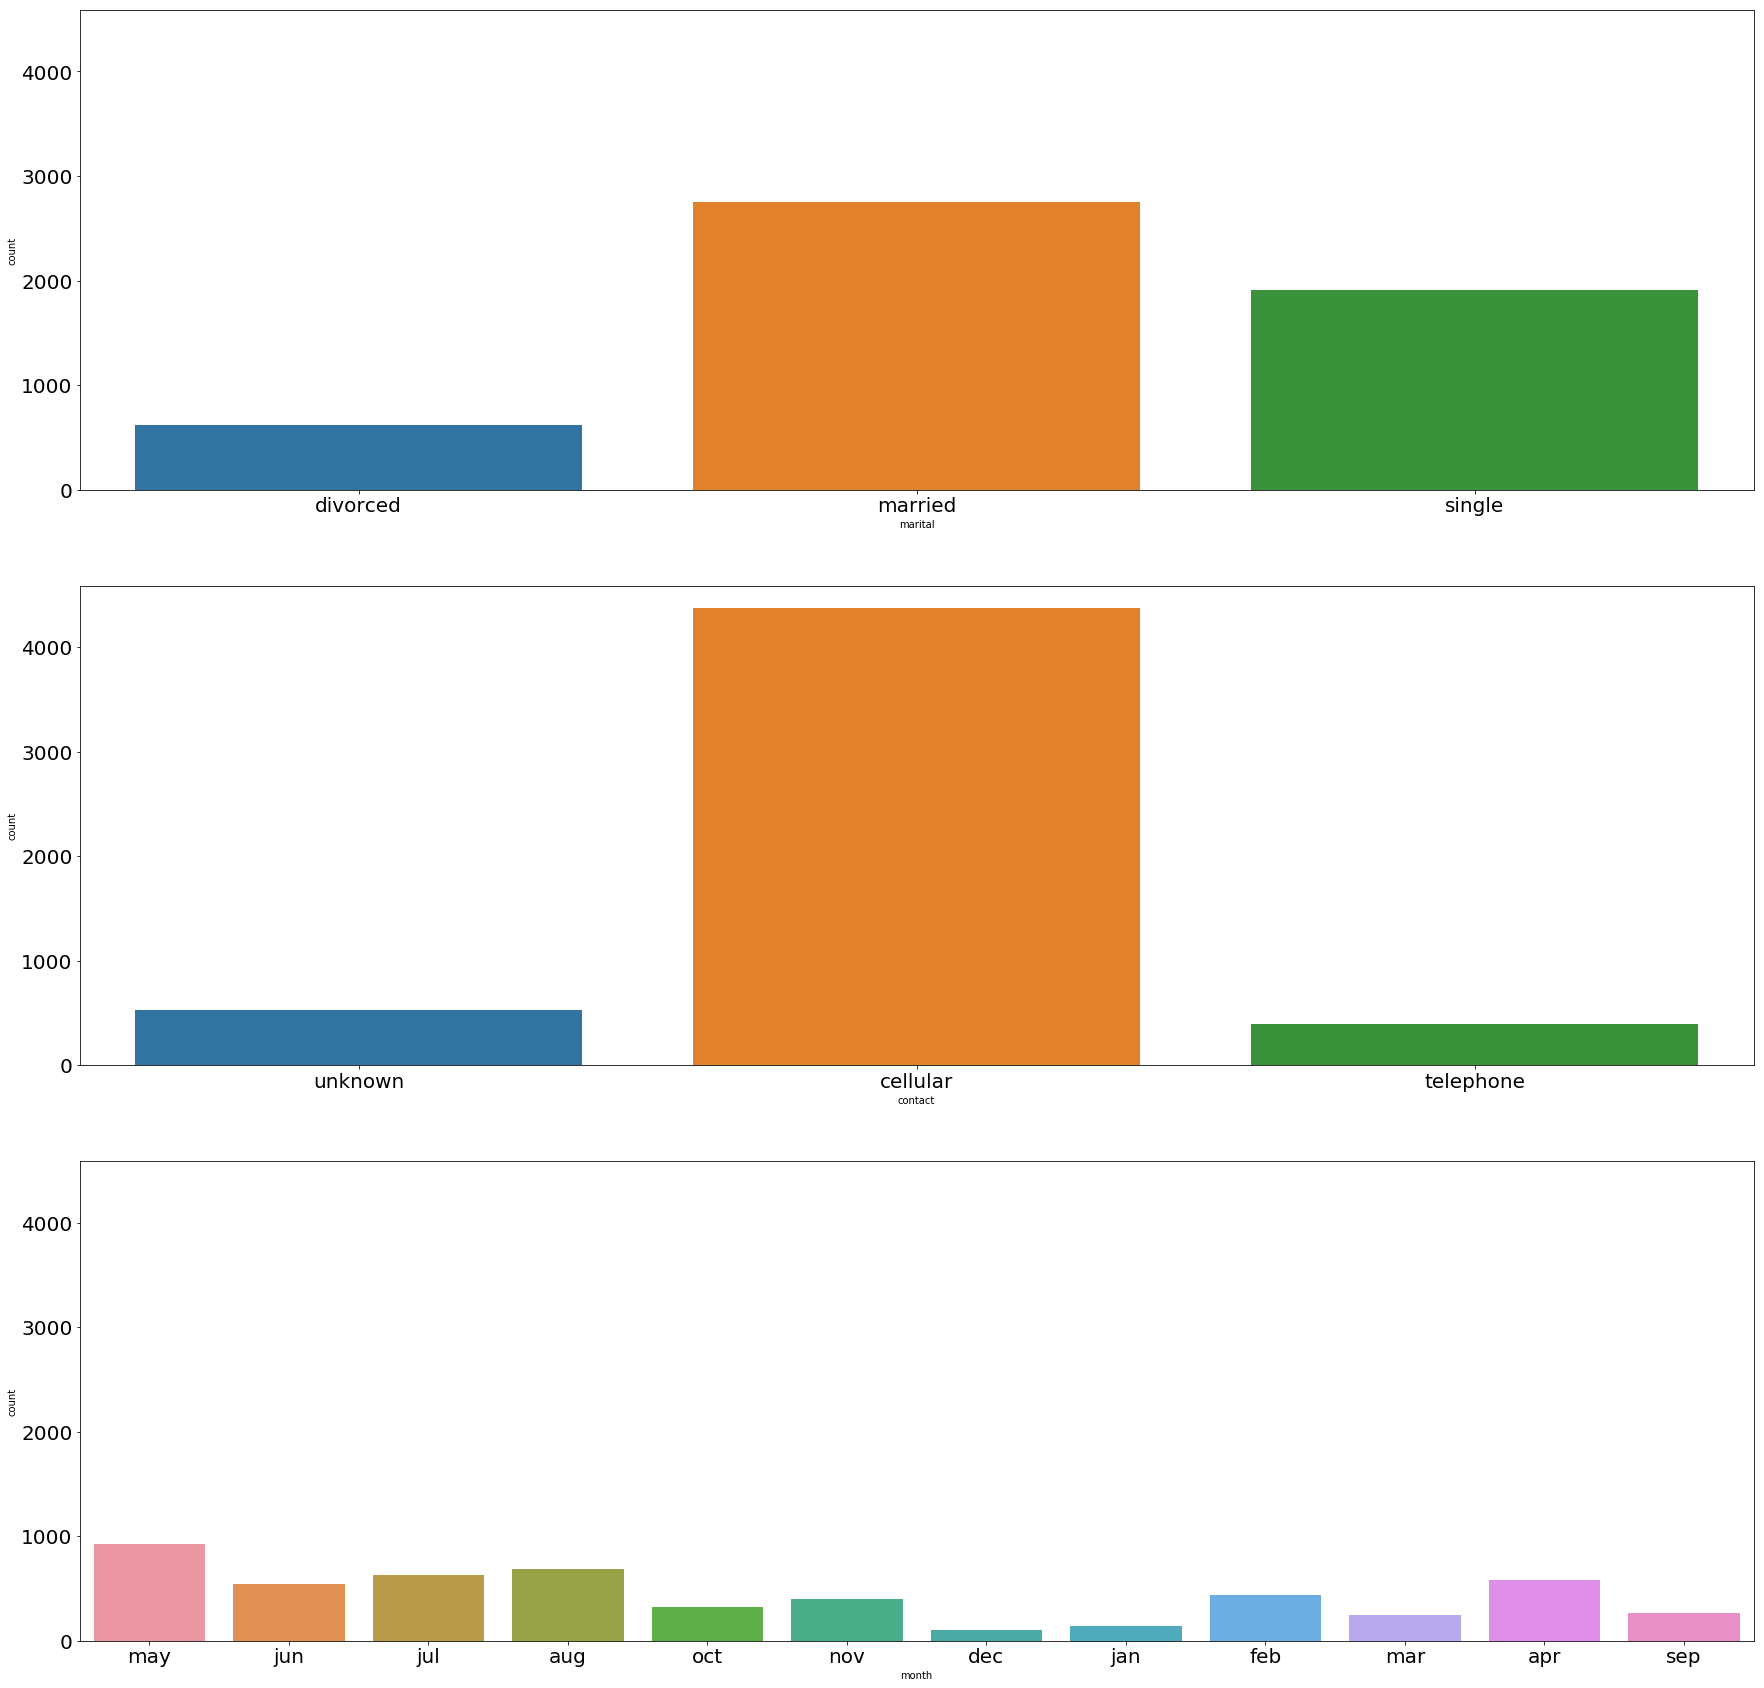

In [6]:
# Visualization data
f, axes =  plt.subplots(3, 1, figsize=(30,30), sharey=True)
a = sns.countplot(x = df[df["y"] == "yes"]["marital"].sort_values(), ax=axes[0])
a.tick_params(labelsize=20)

b = sns.countplot(x = df[df["y"] == "yes"]["contact"], ax=axes[1])
b.tick_params(labelsize=20)

c = sns.countplot(x = df[df["y"] == "yes"]["month"], ax=axes[2])
c.tick_params(labelsize=20)

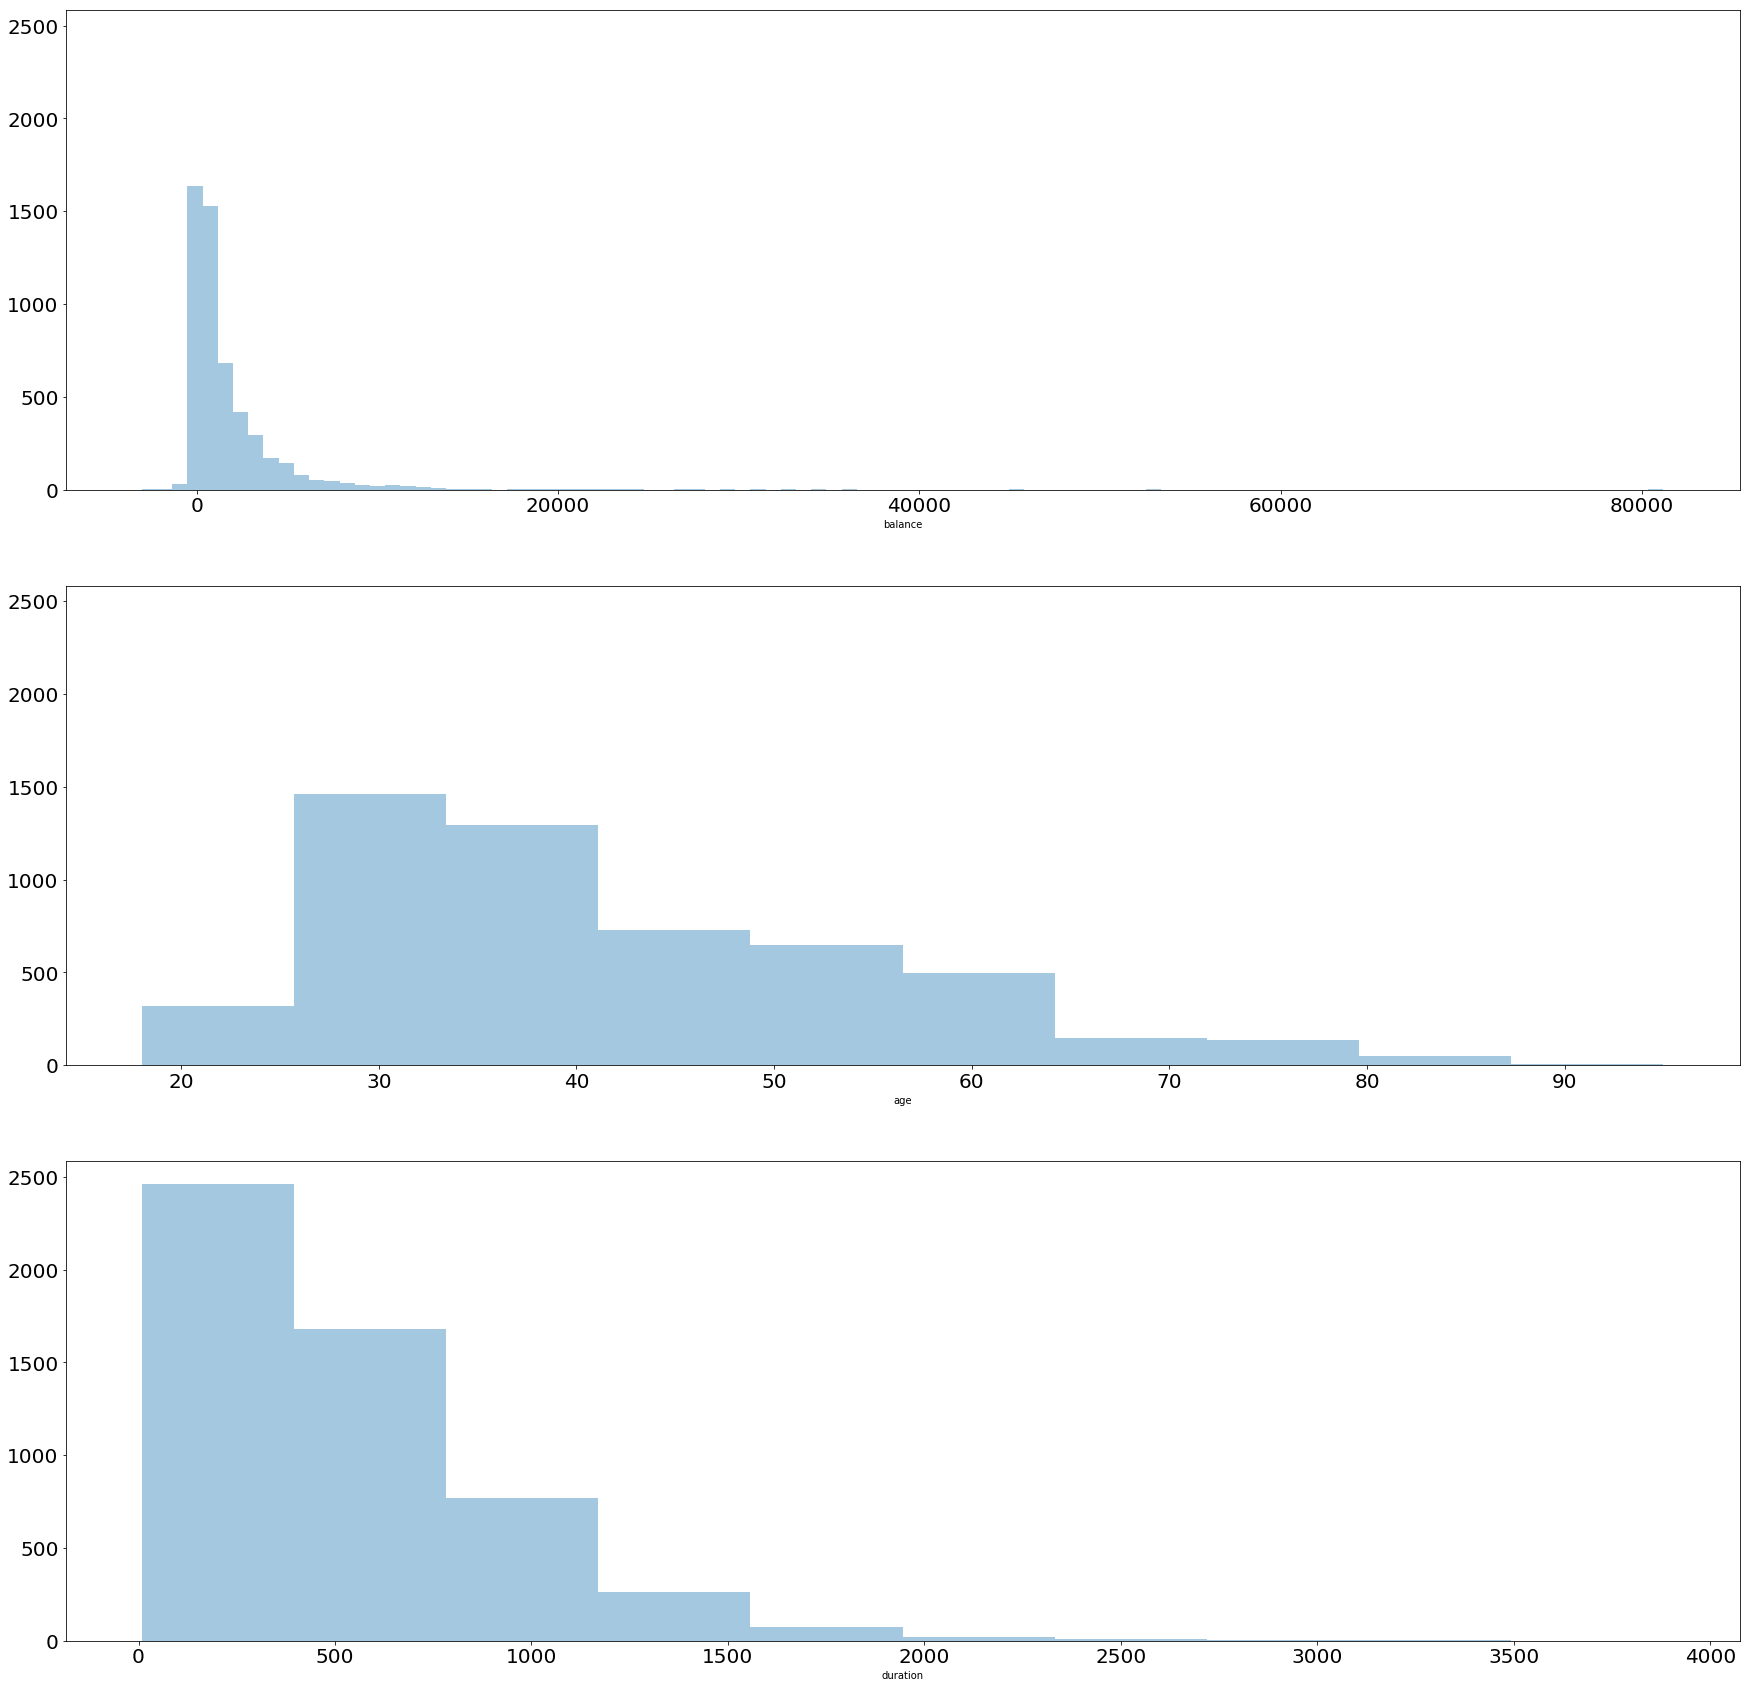

In [7]:
# Visualization data
f, axes =  plt.subplots(3, 1, figsize=(30,30), sharey=True)
a = sns.distplot(df[df["y"] == "yes"]["balance"].sort_values(), ax=axes[0], bins=100, kde=False)
a.tick_params(labelsize=20)

b = sns.distplot(df[df["y"] == "yes"]["age"], ax=axes[1], bins=10, kde=False)
b.tick_params(labelsize=20)

c = sns.distplot(df[df["y"] == "yes"]["duration"], ax=axes[2], bins=10, kde=False)
c.tick_params(labelsize=20)

In [8]:
df[(df["y"] == "yes") & df["balance"] < 1000].shape

(45211, 17)

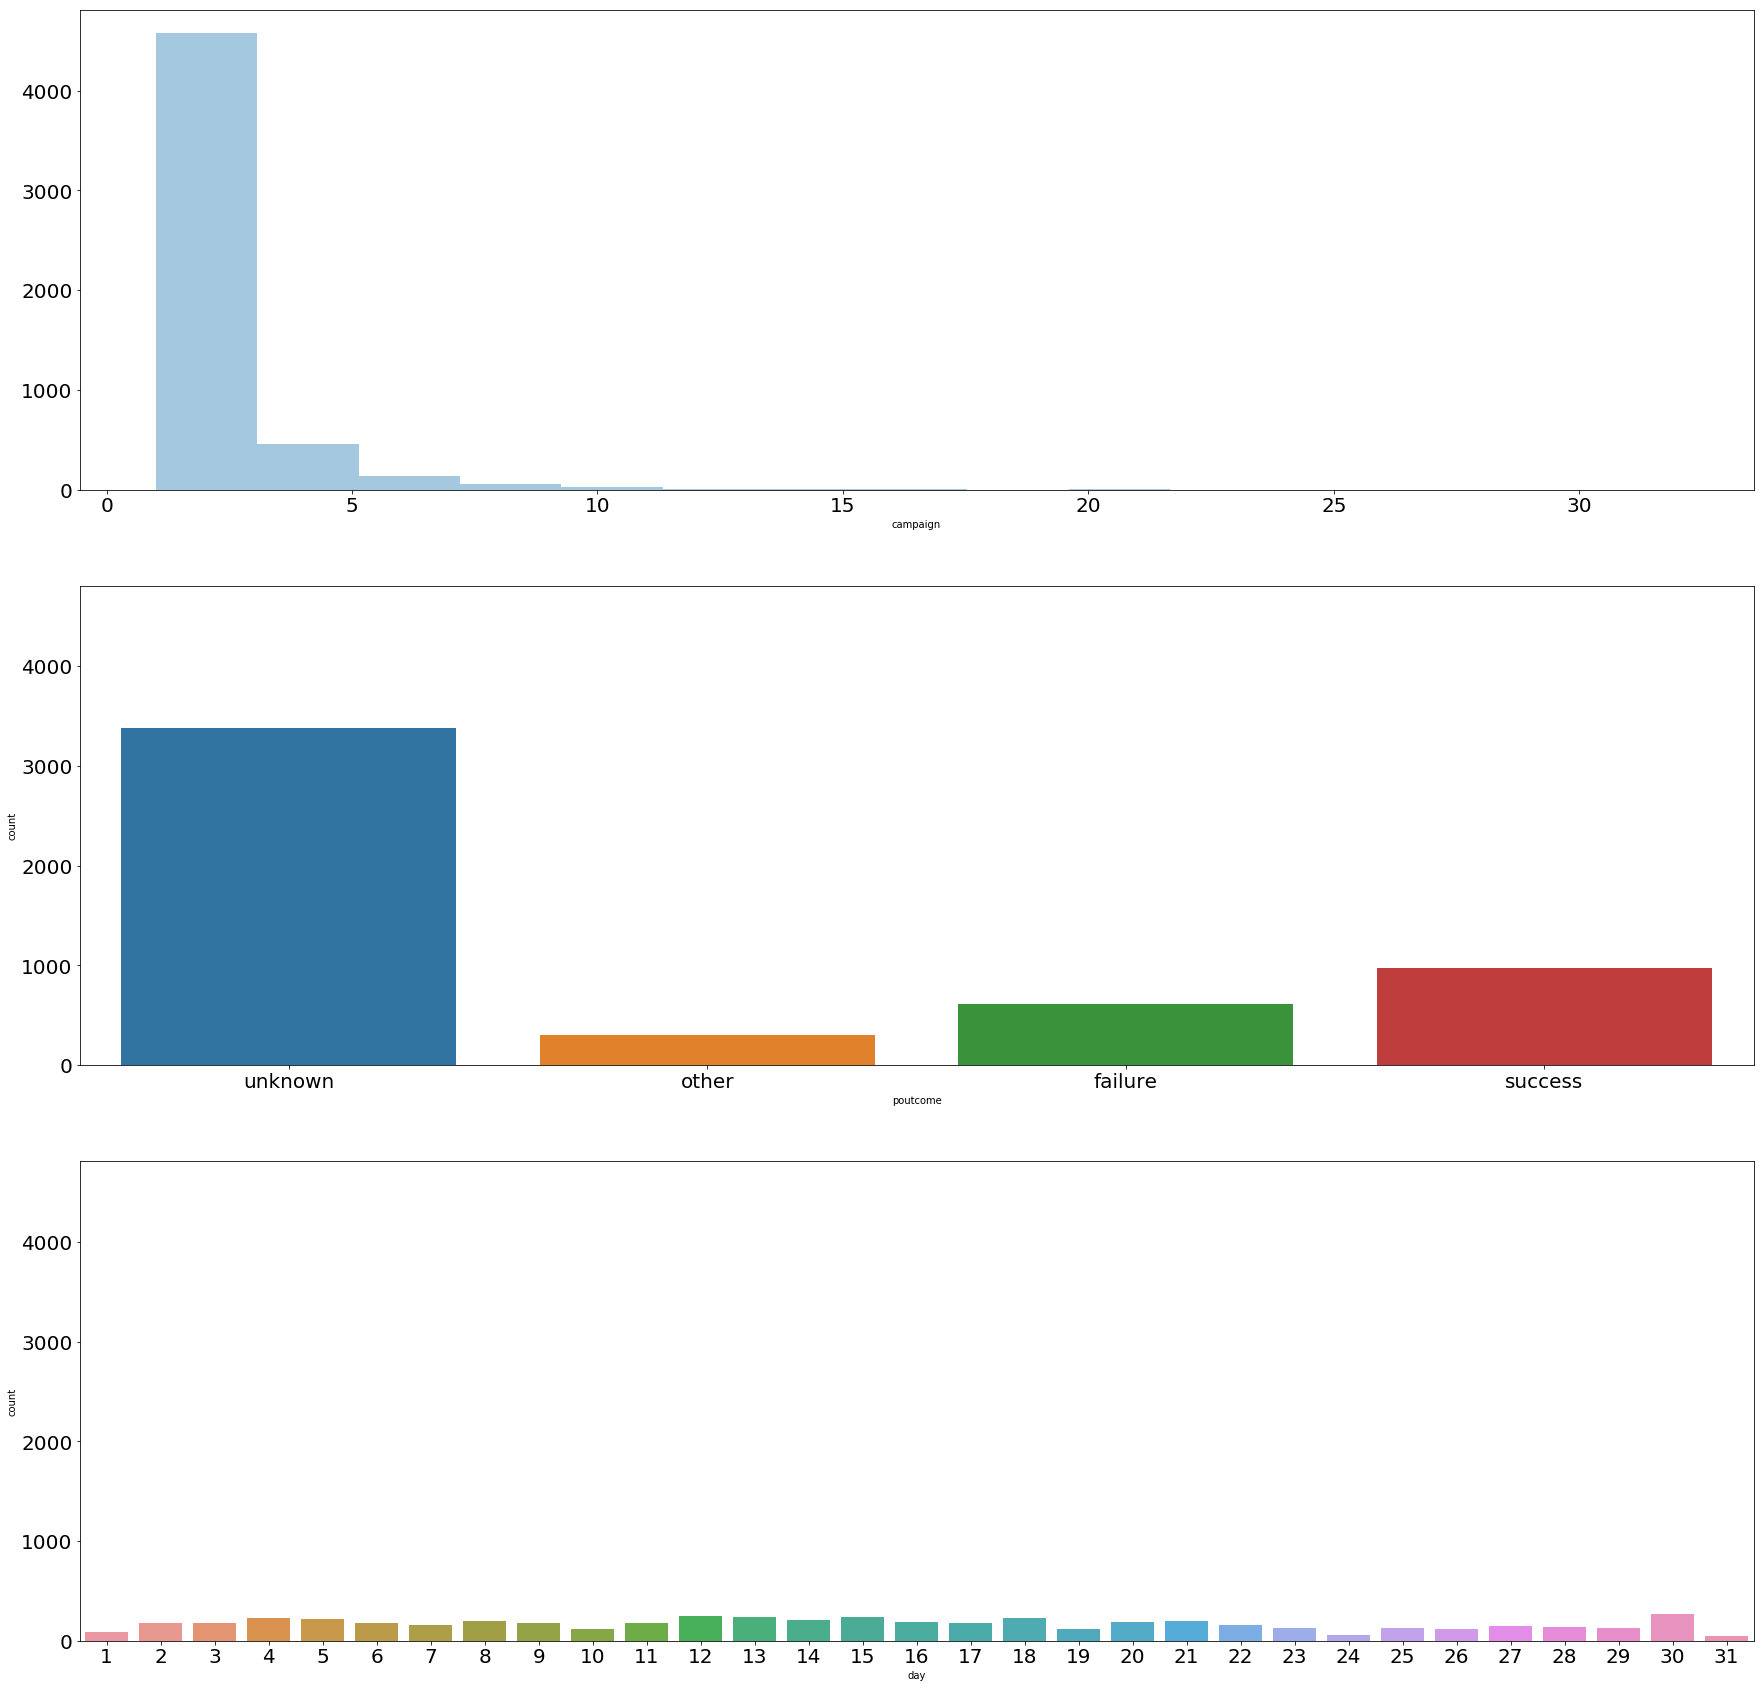

In [9]:
f, axes = plt.subplots(3, 1, figsize=(30,30), sharey=True)
a = sns.distplot(df[df["y"] == "yes"]["campaign"], bins=15, ax=axes[0], kde=False)
a.tick_params(labelsize=20)

b = sns.countplot(x = df[df["y"] == "yes"]["poutcome"], ax=axes[1])
b.tick_params(labelsize=20)

c = sns.countplot(x = df[df["y"] == "yes"]["day"], ax=axes[2])
c.tick_params(labelsize=20)

In [10]:
# drop column day and month
df = df.drop(["month", "day"], axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no


In [11]:
# Making categorical feature into integer
df["job"] = df["job"].astype("category")
df["marital"] = df["marital"].astype("category")
df["education"] = df["education"].astype("category")
df["default"] = df["default"].astype("category")
df["housing"] = df["housing"].astype("category")
df["loan"] = df["loan"].astype("category")
df["contact"] = df["contact"].astype("category")
df["poutcome"] = df["poutcome"].astype("category")
df["y"] = df["y"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null category
balance      45211 non-null int64
housing      45211 non-null category
loan         45211 non-null category
contact      45211 non-null category
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
y            45211 non-null category
dtypes: category(9), int64(6)
memory usage: 2.5 MB


In [12]:
# Change into int
df["job_int"] = df["job"].cat.codes
df["marital_int"] = df["marital"].cat.codes
df["education_int"] = df["education"].cat.codes
df["default_int"] = df["default"].cat.codes
df["housing_int"] = df["housing"].cat.codes
df["loan_int"] = df["loan"].cat.codes
df["contact_int"] = df["contact"].cat.codes
df["poutcome_int"] = df["poutcome"].cat.codes
df["y_int"] = df["y"].cat.codes
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,y,job_int,marital_int,education_int,default_int,housing_int,loan_int,contact_int,poutcome_int,y_int
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,...,no,4,1,2,0,1,0,2,3,0
1,44,technician,single,secondary,no,29,yes,no,unknown,151,...,no,9,2,1,0,1,0,2,3,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,...,no,2,1,1,0,1,1,2,3,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,...,no,1,1,3,0,1,0,2,3,0
4,33,unknown,single,unknown,no,1,no,no,unknown,198,...,no,11,2,3,0,0,0,2,3,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 24 columns):
age              45211 non-null int64
job              45211 non-null category
marital          45211 non-null category
education        45211 non-null category
default          45211 non-null category
balance          45211 non-null int64
housing          45211 non-null category
loan             45211 non-null category
contact          45211 non-null category
duration         45211 non-null int64
campaign         45211 non-null int64
pdays            45211 non-null int64
previous         45211 non-null int64
poutcome         45211 non-null category
y                45211 non-null category
job_int          45211 non-null int8
marital_int      45211 non-null int8
education_int    45211 non-null int8
default_int      45211 non-null int8
housing_int      45211 non-null int8
loan_int         45211 non-null int8
contact_int      45211 non-null int8
poutcome_int     45211 non-null int

In [14]:
listJob = df["job"].sort_values().unique()

listMarital = df["marital"].sort_values().unique()

listEd = df["education"].sort_values().unique()

listDef = df["default"].sort_values().unique()

listHouse = df["housing"].sort_values().unique()

listLoan = df["loan"].sort_values().unique()

listCon = df["contact"].sort_values().unique()

listOut = df["poutcome"].sort_values().unique()

listTar = df["y"].sort_values().unique()


In [39]:
listOut.categories

Index(['failure', 'other', 'success', 'unknown'], dtype='object')

In [37]:
df_train = df[["age", "job_int", 
               "marital_int", "education_int", "default_int", "balance", 
               "housing_int", "loan_int", "contact_int", "duration", "campaign",
               "pdays", "previous", "poutcome_int", "y"]]
df_train.head()

,age,job_int,marital_int,education_int,default_int,balance,housing_int,loan_int,contact_int,duration,campaign,pdays,previous,poutcome_int,y
0,58,4,1,2,0,2143,1,0,2,261,1,-1,0,3,no
1,44,9,2,1,0,29,1,0,2,151,1,-1,0,3,no
2,33,2,1,1,0,2,1,1,2,76,1,-1,0,3,no
3,47,1,1,3,0,1506,1,0,2,92,1,-1,0,3,no
4,33,11,2,3,0,1,0,0,2,198,1,-1,0,3,no


In [23]:
features = ["age", "job_int", 
               "marital_int", "education_int", "default_int", "balance", 
               "housing_int", "loan_int", "contact_int", "duration", "campaign",
               "pdays", "previous", "poutcome_int"]

In [24]:
# Pisahkan 80 dan 20 untuk train dan testing
msk = np.random.rand(len(df_train)) < 0.8
df_test = df_train[~msk]
df_train = df_train[msk]

In [25]:
print(df_train.shape)
print(df_test.shape)

(36289, 15)
(8922, 15)


### Model LightGBM

In [26]:
lgb = lightgbm.LGBMClassifier(n_estimators=650, max_depth=5, learning_rate=0.005, colsample_bytree=0.6, random_state=2019)

In [27]:
lgb.fit(df_train[features], df_train["y"])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        importance_type='split', learning_rate=0.005, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=650, n_jobs=-1, num_leaves=31, objective=None,
        random_state=2019, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
pickle.dump(lgb, open('lgb.pkl', 'wb'))

In [29]:
model = pickle.load(open('lgb.pkl', 'rb'))

In [30]:
preds = model.predict_proba(df_test[features])[:,1]
preds_tr = model.predict_proba(df_train[features])[:,1]

In [31]:
metrics.roc_auc_score(df_train["y"], preds_tr), metrics.roc_auc_score(df_test["y"], preds)

(0.918383795966705, 0.9044006139854812)

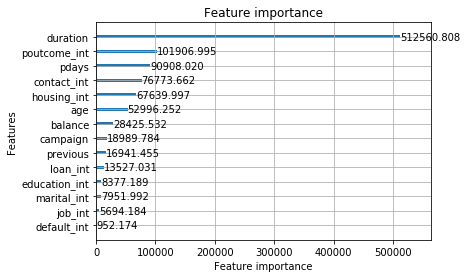

In [32]:
lightgbm.plot_importance(lgb, importance_type="gain")

### Model Logistic Regression

In [26]:
logReg = LogisticRegression(random_state=0, solver='lbfgs',
                           multi_class='multinomial')

In [27]:
logReg.fit(df_train[features], df_train["y"])
pickle.dump(logReg, open('logReg.pkl', 'wb'))

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [28]:
model1 = pickle.load(open('logReg.pkl', 'rb'))

In [31]:
prediction = model1.predict_proba(df_test[features])[:,1]
prediction_tr = model1.predict_proba(df_train[features])[:,1]

In [32]:
metrics.roc_auc_score(df_train["y"], prediction_tr), metrics.roc_auc_score(df_test["y"], prediction)

(0.8344376126231525, 0.8458140813612495)

### Model yang akan digunakan adalah model Lgbm